# Mini Project 2: Where Will Dicty* Meet?

**Course:** Applied Data Science for Single-Cell Genomics  
**Student:** María Dolores Navarro Maturana  

In this notebook I use microscopy movies of *Dictyostelium discoideum* stored as Zarr stacks to predict where cells will eventually aggregate. From early frames of each movie, I train neural models to predict either the future aggregation center or a spatial probability map. I compare three models and evaluate them using center error and robustness across different time windows and spatial resolutions.


## 1. Problem & Approach

**Problem.** Each experiment is a time-lapse movie of Dicty cells that eventually aggregate into one or more dense clusters. The goal is to “beat Dicty to its own meeting spot”: given only the first N frames of the movie, predict where aggregation will occur in the final frames.

I formulate two related prediction tasks:

1. **Center prediction (coordinates)**  
   Predict the final aggregation center as (x, y).

2. **Hotspot map prediction (heatmap)**  
   Output a 2D probability map over pixels indicating how likely each pixel is to belong to the future aggregation region.

**Overall approach.**

1. Load the Zarr movies for three experiments (mixin44, mixin57, mixin64).
2. Preprocess: z-collapse and normalize intensities.
3. Define ground-truth aggregation centers from the final frames.
4. Train three models:

   - **Model 1 – TinyCNN next-frame baseline**  
     Conv3D → Conv2D model predicting the next frame given K past frames.
   - **Model 2 – CenterRegressor**  
     CNN encoder that predicts the final aggregation coordinates.
   - **Model 3 – HeatmapCNN**  
     CNN predicting a Gaussian heatmap centered at the aggregation site.

5. Evaluate the models on:
   - Center error (µm)
   - Performance as a function of input window size
   - Robustness across spatial resolution



## 2. Methods

### 2.1 Data

I use three Zarr movies provided by the instructors:

- `mixin_test44 / 2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr`
- `mixin_test57 / 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr`
- `mixin_test64 / ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr`

Each Zarr store has shape roughly `(T, Z, C, Y, X)` and is collapsed along the z and channel axes into `(T, H, W)`.

From `experiment_info.xlsx`:

| Experiment | Pixel size (µm) | Time interval (min, subsampled) | Timepoints used | Notes |
|-----------|-----------------|----------------------------------|-----------------|-------|
| mixin44   | 2.41            | 15                               | 34              | NC105.1, 10x objective, z=32 |
| mixin57   | 2.41            | 10                               | 40              | NC28.1, 10x objective, z=16  |
| mixin64   | 1.28            | 10                               | 20              | NC28.1, 10x objective, z=48 (downsampled ×4 in z) |

I treat each movie as a 3D tensor `(T, H, W)` of normalized fluorescence intensities.

**Channels.** I only use the red/FarRed channel.

**Frame ranges.** For each experiment I use all timepoints but compute labels based on the last few frames (see below).

**Masks.** I do not use external masks; aggregation regions are inferred from intensity patterns in the final frames.


### 2.2 Preprocessing

1. **Zarr loading & z-/channel projection**
   - I load each experiment from its .zarr store using zarr.open() and convert it to a NumPy array.
   - The raw arrays have shapes such as:
   
      `(T, Z, Y, X)` or
    
     `(T, Z, C, Y, X)` (e.g., (34, 1, 32, 256, 256) for mixin44).
   - I collapse all non-spatial axes (z and channel) using a max projection to obtain a single 2D frame per timepoint:
   $$I_{t,y,x} = \max_{z,c} I_{t,z,c,y,x}.$$
   - This produces a movie with shape (T, H, W) (here H = W = 256).

2. **Normalization**
   - For each experiment, rescale intensities to $[0,1]$:
   $$
   I' = \frac{I - \min(I)}{\max(I)-\min(I) + 10^{-8}}.
   $$
   - This ensures consistent dynamic ranges across `mixin44`, `mixin57`, and `mixin64`.

3. **Denoising / smoothing**
   - I did not apply any additional filtering (no Gaussian blur, no temporal smoothing).
   - Models are trained directly on the max-projected + normalized frames.

4. **Dataset construction and splits**

    **Next-frame prediction baseline (Model 1 — TinyCNN)**

    - I use only mixin44 for this task.
    - I build a sliding-window dataset (WindowedFrames) with window size K = 4.
      - Input: frames t, t+1, t+2, t+3 → shape (K, 1, H, W)
      - Target: frame t+4 → shape (1, H, W)
    - All possible windows are extracted with stride 1.
    - I split these windows into:
      - 70% train
      - 15% validation
      - 15% test

       (using `random_split` with a fixed random seed)

    **Aggregation-center models (Model 2 — CenterRegressor, Model 3 — HeatmapCNN)**
    - For each movie, I compute a single ground-truth aggregation center using the intensity-weighted center of mass of the last 5 frames:
    $$
    x_{\text{cm}} = \frac{\sum_{t,y,x} x I_{t,y,x}}{\sum_{t,y,x} I_{t,y,x}} \quad \text{ and } \quad y_{\text{cm}} = \frac{\sum_{t,y,x} y I_{t,y,x}}{\sum_{t,y,x} I_{t,y,x}}.
    $$
    - From each movie, I extract sliding windows of length N = 6 with stride 1:
      - **Input**: first 6 frames of the window (N, H, W)
      - **Target (Model 2)**: the COM coordinates (cx, cy) in pixels
      - **Target (Model 3)**: a Gaussian heatmap centered at the COM

    - All windows across the three experiments are concatenated (total: **76** samples).
    - I split into:
      - 80% training
      - 20% validation

      using `random_split` with a fixed seed.

    **Additional preprocessing for Model 3 (HeatmapCNN)**
    - Input frames are downsampled by a factor of 2 using 2×2 average pooling (256×256 → 128×128).
    - The Gaussian heatmaps are generated at the same resolution, with both:
      - center coordinates and
      - Gaussian width σ

      scaled accordingly.

### 2.3 Task & Label Construction

For each experiment, I define a single ground-truth aggregation center based on the end of the movie. The idea is to extract where the cells have finally converged and use that position as the target for all early-frame windows from that movie.

**1. Late-frame selection.**  
I use the last 5 frames of each movie (or fewer if the movie is shorter), where the
aggregation structure is already formed.

**2. Intensity-weighted center of mass (COM).**  
For those final frames, I compute a COM over the averaged image:
$$
x_{\text{cm}} =
\frac{\sum_{t,y,x} x\, I_{t,y,x}}{\sum_{t,y,x} I_{t,y,x}}, \qquad
y_{\text{cm}} =
\frac{\sum_{t,y,x} y\, I_{t,y,x}}{\sum_{t,y,x} I_{t,y,x}}.
$$
This produces a single center $(x_{\text{cm}}, y_{\text{cm}})$ in pixel units.

**3. Use of COM for all windows.**  
Each early-frame window extracted from the same movie is assigned the
same COM label.  
- For **Model 2 (CenterRegressor)**, the label is the coordinate vector $(cx, cy)$.  
- For **Model 3 (HeatmapCNN)**, the label is a Gaussian heatmap centered at the
  downsampled COM, with σ scaled to the same resolution.

**4. Multiple aggregates.**  
In practice, all three movies show a dominant bright aggregate at the end. Therefore I use the single brightest COM as the ground-truth center, without attempting to model multiple clusters.


In [ ]:
#@title Setup (optional installs)
!pip -q install tifffile h5py scikit-image tqdm
!pip install zarr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 106.3 MB/s eta 0:00:00


In [ ]:
#@title Imports & seed
import os, zarr, random, numpy as np, matplotlib.pyplot as plt, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

try:
    import tifffile as tiff
except Exception:
    tiff = None
try:
    import h5py
except Exception:
    h5py = None

def set_seed(seed=7):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7); DEVICE


'cpu'

In [ ]:
#@title Load Data
import os

root = "/content/drive"
for path, dirs, files in os.walk(root):
    for d in dirs:
        if d.endswith(".zarr"):
            print("FOUND:", os.path.join(path, d))


Mounted at /content/drive
Loading from: /content/drive/.shortcut-targets-by-id/1ibLCyruTBGNOaj_TanaORkELVX8TGRBB/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr
raw zarr shape: (34, 1, 32, 256, 256)
final movie shape: (34, 256, 256) min/max: 0.0 1.0


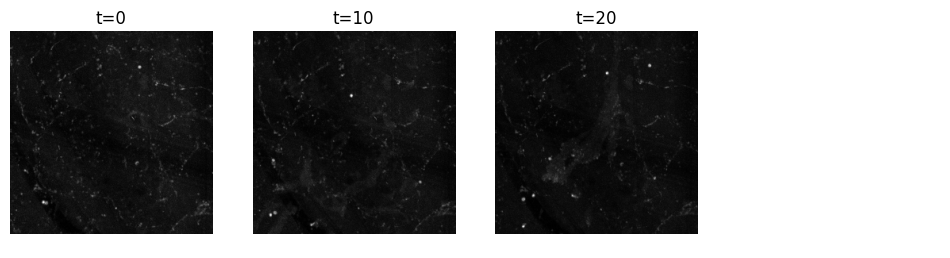

In [ ]:
# Install zarr first
!pip install zarr

# 1) Load real Dicty data from Zarr instead of synthetic demo

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, numpy as np, zarr
import matplotlib.pyplot as plt

DATA_ROOT = "/content/drive/.shortcut-targets-by-id/1ibLCyruTBGNOaj_TanaORkELVX8TGRBB/Data"

def read_zarr_movie(path, z_agg="max"):
    arr = zarr.open(path, mode="r")
    data = np.array(arr)
    print("raw zarr shape:", data.shape)

    if data.ndim == 4:       # T, Z, Y, X
        axis_to_reduce = (1,)
    elif data.ndim == 5:     # T, Z, C, Y, X  or T,C,Z,Y,X
        axis_to_reduce = tuple(range(1, data.ndim - 2))
    elif data.ndim == 3:     # T,H,W
        axis_to_reduce = ()
    else:
        raise ValueError(f"Unexpected zarr shape {data.shape}")

    if axis_to_reduce:
        if z_agg == "max":
            data = data.max(axis=axis_to_reduce)
        else:
            data = data.mean(axis=axis_to_reduce)

    data = data.astype(np.float32)
    data = (data - data.min()) / (data.max() - data.min() + 1e-8)

    print("final movie shape:", data.shape, "min/max:", float(data.min()), float(data.max()))
    return data


expt_folder = "mixin_test44"
zarr_name   = "2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr"

DATA_PATH = os.path.join(DATA_ROOT, expt_folder, zarr_name)
print("Loading from:", DATA_PATH)

raw = read_zarr_movie(DATA_PATH, z_agg="max")

def show_frames(arr, frames=(0,10,20,40)):
    fig,axs = plt.subplots(1,len(frames), figsize=(12,3))
    for ax,t in zip(axs, frames):
        if t < arr.shape[0]:
            ax.imshow(arr[t], cmap="gray")
            ax.set_title(f"t={t}")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.show()

show_frames(raw)


In [ ]:
#@title Dataset & loaders
from torch.utils.data import Dataset, DataLoader, random_split
class WindowedFrames(Dataset):
    def __init__(self, arr, K=4):
        if arr.ndim==3: arr = arr[:,None,...]
        self.arr = arr.astype(np.float32); self.K=K
    def __len__(self): return self.arr.shape[0]-self.K
    def __getitem__(self,i):
        x = torch.from_numpy(self.arr[i:i+self.K])     # (K,1,H,W)
        y = torch.from_numpy(self.arr[i+self.K])       # (1,H,W)
        return x,y

K=4; ds=WindowedFrames(raw,K)
n_tr=int(0.7*len(ds)); n_val=int(0.15*len(ds)); n_te=len(ds)-n_tr-n_val
tr,val,te = random_split(ds,[n_tr,n_val,n_te],generator=torch.Generator().manual_seed(0))
tr_loader=DataLoader(tr,batch_size=16,shuffle=True); val_loader=DataLoader(val,batch_size=32); te_loader=DataLoader(te,batch_size=32)
len(tr),len(val),len(te)

(21, 4, 5)

## 3. Models
I implement three models of increasing sophistication.



### 3.1 Model 1 – TinyCNN next-frame prediction (baseline)

- **Input:** last K frames, shape `(K, 1, H, W)`
- **Output:** prediction of frame `t+1`, shape `(1, H, W)`
- **Architecture:**
  - Conv3D over time+space → 8 feature maps.
  - Conv2D → 16 feature maps → Conv2D → 1 output channel.
- **Loss:** Mean Squared Error (MSE) between predicted frame and true frame.
- **Purpose:** sanity-check that the network can model local motion and brightness patterns. This baseline does not directly predict the aggregation center but provides a reference for “how predictable” the movie is.


[TinyCNN] epoch 01  train MSE=0.0360  val MSE=0.0316
[TinyCNN] epoch 05  train MSE=0.0197  val MSE=0.0173
[TinyCNN] epoch 10  train MSE=0.0082  val MSE=0.0067
[TinyCNN] epoch 15  train MSE=0.0019  val MSE=0.0013
[TinyCNN] epoch 20  train MSE=0.0002  val MSE=0.0002
[TinyCNN] Test MSE: 0.0002


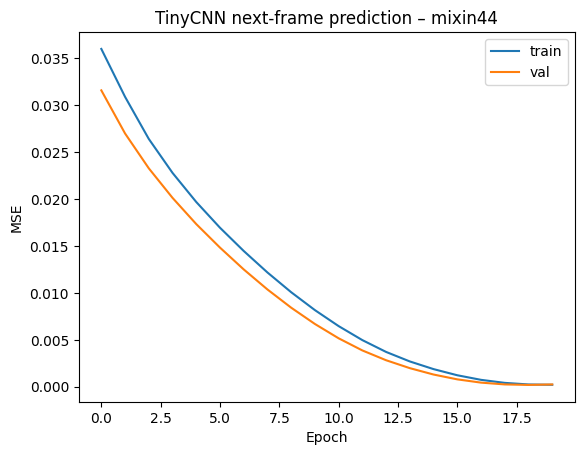

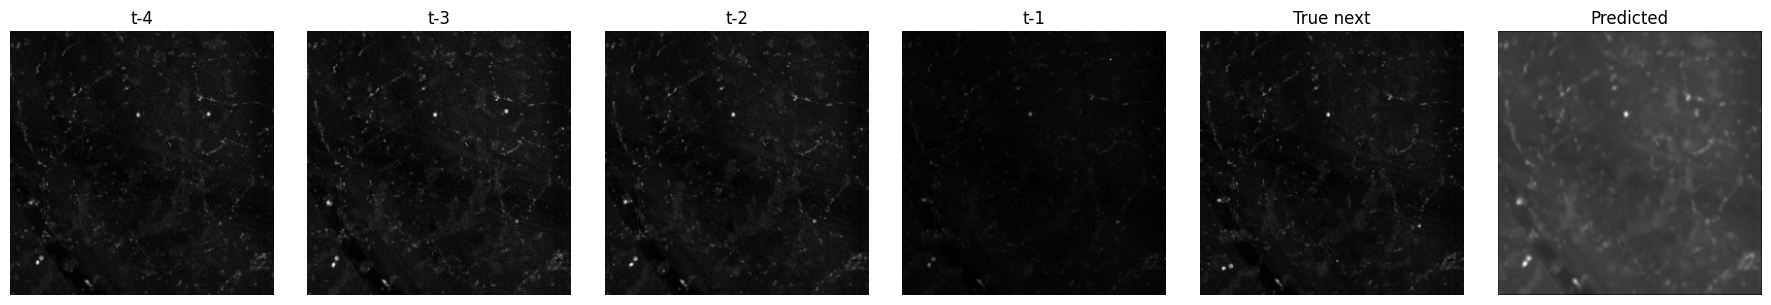

In [ ]:
class TinyCNN(nn.Module):
    """
    Baseline model:
    - Input: K past frames (K,1,H,W)
    - Output: predicted next frame (1,H,W)
    Architecture: Conv3D encoder over time, then Conv2D head.
    """
    def __init__(self, K):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, x):
        # x: (B, K, 1, H, W)
        x = x.permute(0, 2, 1, 3, 4)   # -> (B, 1, K, H, W)
        z = self.enc(x).squeeze(2)     # -> (B, 8, H, W)
        out = self.head(z)             # -> (B, 1, H, W)
        return out


# Instantiate model, optimizer, loss
model = TinyCNN(K).to(DEVICE)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()


def train_epoch(model, loader, loss_fn, optimizer, device=DEVICE):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, loss_fn, device=DEVICE):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


# - Train baseline on mixin44 -
n_epochs = 20
hist_tr, hist_val = [], []

for ep in range(1, n_epochs + 1):
    tr_loss = train_epoch(model, tr_loader, loss_fn, opt, DEVICE)
    va_loss = evaluate(model, val_loader, loss_fn, DEVICE)
    hist_tr.append(tr_loss)
    hist_val.append(va_loss)

    if ep % 5 == 0 or ep == 1 or ep == n_epochs:
        print(f"[TinyCNN] epoch {ep:02d}  train MSE={tr_loss:.4f}  val MSE={va_loss:.4f}")

# Final test MSE
test_mse = evaluate(model, te_loader, loss_fn, DEVICE)
print(f"[TinyCNN] Test MSE: {test_mse:.4f}")

# Plot training curves
plt.figure()
plt.plot(hist_tr, label="train")
plt.plot(hist_val, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("TinyCNN next-frame prediction – mixin44")
plt.legend()
plt.show()


# - Qualitative example -
@torch.no_grad()
def show_example(idx=0):
    """
    Show K input frames, the true next frame, and the predicted next frame.
    """
    xb, yb = ds[idx]                # xb: (K,1,H,W), yb: (1,H,W)
    xb_batch = xb.unsqueeze(0).to(DEVICE)   # (1,K,1,H,W)
    pred = model(xb_batch).cpu().squeeze().numpy()
    true = yb.squeeze().numpy()
    history = xb[:, 0].numpy()      # (K,H,W)

    cols = history.shape[0] + 2
    fig, axs = plt.subplots(1, cols, figsize=(3 * cols, 3))

    # Past K frames
    for k in range(history.shape[0]):
        axs[k].imshow(history[k], cmap="gray")
        axs[k].set_title(f"t-{history.shape[0] - k}")
        axs[k].axis("off")

    # True next frame
    axs[-2].imshow(true, cmap="gray")
    axs[-2].set_title("True next")
    axs[-2].axis("off")

    # Predicted next frame
    axs[-1].imshow(pred, cmap="gray")
    axs[-1].set_title("Predicted")
    axs[-1].axis("off")

    plt.tight_layout()
    plt.show()

# Show one qualitative prediction
show_example(idx=5)


In [ ]:
# Load 3 movies
movies = {}

for expt in ["mixin_test44", "mixin_test57", "mixin_test64"]:
    folder = os.path.join(DATA_ROOT, expt)
    files = [f for f in os.listdir(folder)
             if f.endswith(".zarr") and "subsampled" in f]

    if len(files) == 0:
        raise ValueError(f"No subsampled .zarr file found in {folder}")

    zpath = os.path.join(folder, files[0])
    print("Loading", zpath)

    movies[expt] = read_zarr_movie(zpath)


Loading /content/drive/.shortcut-targets-by-id/1ibLCyruTBGNOaj_TanaORkELVX8TGRBB/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr
raw zarr shape: (34, 1, 32, 256, 256)
final movie shape: (34, 256, 256) min/max: 0.0 1.0
Loading /content/drive/.shortcut-targets-by-id/1ibLCyruTBGNOaj_TanaORkELVX8TGRBB/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr
raw zarr shape: (40, 1, 16, 256, 256)
final movie shape: (40, 256, 256) min/max: 0.0 1.0
Loading /content/drive/.shortcut-targets-by-id/1ibLCyruTBGNOaj_TanaORkELVX8TGRBB/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr
raw zarr shape: (20, 1, 48, 256, 256)
final movie shape: (20, 256, 256) min/max: 0.0 1.0


In [ ]:
print(movies.keys())

dict_keys(['mixin_test44', 'mixin_test57', 'mixin_test64'])


### 3.2 Model 2 – Coordinate regressor

- **Task:** Given the first N frames (N=6), predict the final aggregation center \((x, y)\).
- **Architecture:**
  - 3D or 2D CNN encoder over the N frames → global average pooling → fully-connected layers → 2 outputs (x, y) in pixel units.
- **Loss:** MSE between predicted and true center coordinates.
- **Training:** train on early-frame windows from each experiment; validate on held-out windows/timepoints.

CenterDataset for mixin_test44 with movie shape (34, 256, 256)
CenterDataset for mixin_test57 with movie shape (40, 256, 256)
CenterDataset for mixin_test64 with movie shape (20, 256, 256)
#center samples: total=76, train=60, val=16
[CenterRegressor] epoch 001  train MSE=15452.05  val MSE=15243.77
[CenterRegressor] epoch 020  train MSE=79.53  val MSE=129.11
[CenterRegressor] epoch 040  train MSE=39.28  val MSE=51.62
[CenterRegressor] epoch 060  train MSE=23.98  val MSE=30.89
[CenterRegressor] epoch 080  train MSE=15.71  val MSE=19.30
[CenterRegressor] epoch 100  train MSE=12.37  val MSE=14.68
[CenterRegressor] epoch 120  train MSE=11.39  val MSE=12.37
[CenterRegressor] epoch 140  train MSE=10.58  val MSE=11.36
[CenterRegressor] epoch 160  train MSE=10.43  val MSE=10.73
[CenterRegressor] epoch 180  train MSE=9.35  val MSE=10.12
[CenterRegressor] epoch 200  train MSE=8.58  val MSE=9.47


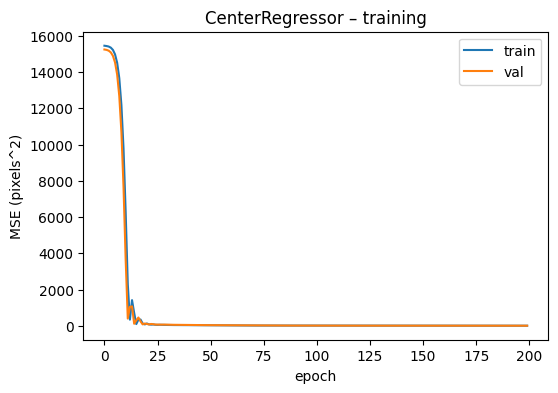

In [ ]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split

# - 1. Helper: compute aggregation center from final frames -
def compute_center_of_mass(movie, last_k=5):
    """
    movie: (T, H, W) array in [0,1]
    last_k: number of final frames to average over
    returns (cx, cy) in pixel coordinates (x=col, y=row)
    """
    T, H, W = movie.shape
    k = min(last_k, T)
    avg_last = movie[-k:].mean(axis=0)         # (H, W)

    mass = avg_last.sum()
    if mass == 0:
        # fallback: center of image
        return np.array([W/2.0, H/2.0], dtype=np.float32)

    ys, xs = np.indices((H, W))
    cy = (avg_last * ys).sum() / mass
    cx = (avg_last * xs).sum() / mass
    return np.array([cx, cy], dtype=np.float32)


# - 2. Dataset: many time windows per movie -
class CenterDataset(Dataset):
    """
    Each sample:
      x: first N frames from some time window  -> shape (N, H, W)
      y: final aggregation center (cx, cy) in pixels
    We reuse the same center for all windows in a movie.
    """
    def __init__(self, movie, N=6, last_k=5, stride=1):
        """
        movie : (T, H, W)
        N     : number of input frames
        last_k: how many final frames to use to define aggregation center
        stride: step between starting indices (1 = all windows)
        """
        self.movie = movie.astype(np.float32)
        self.N = N
        self.stride = stride
        self.center = compute_center_of_mass(movie, last_k=last_k)  # (2,)

        T = movie.shape[0]
        self.start_idxs = list(range(0, T - N, stride))

    def __len__(self):
        return len(self.start_idxs)

    def __getitem__(self, idx):
        i = self.start_idxs[idx]
        x = self.movie[i:i+self.N]          # (N, H, W)
        y = self.center                     # (2,)
        x = torch.from_numpy(x)             # float32
        y = torch.from_numpy(y)             # float32
        return x, y


# - 3. Build dataset from all three movies -
# movies should already exist, e.g.:
# movies = { "mixin_test44": arr44, "mixin_test57": arr57, "mixin_test64": arr64 }

center_ds_list = []
for name, movie in movies.items():
    print(f"CenterDataset for {name} with movie shape {movie.shape}")
    center_ds_list.append(CenterDataset(movie, N=6, last_k=5, stride=1))

full_center_ds = ConcatDataset(center_ds_list)

n_total = len(full_center_ds)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train
train_center_ds, val_center_ds = random_split(
    full_center_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(0)
)

train_center_loader = DataLoader(train_center_ds, batch_size=16, shuffle=True)
val_center_loader   = DataLoader(val_center_ds,   batch_size=16, shuffle=False)

print(f"#center samples: total={n_total}, train={n_train}, val={n_val}")


# - 4. CenterRegressor model (smaller, with global pooling) -
class CenterRegressor(nn.Module):
    def __init__(self, T=6):
        """
        T: number of input frames
        """
        super().__init__()
        # temporal conv: look across T frames at once
        self.temporal = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(T, 3, 3), padding=(0, 1, 1)),
            nn.ReLU()
        )
        # spatial convs on aggregated features
        self.spatial = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 256x256 -> 128x128
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))    # -> (32, 4, 4)
        )
        self.head = nn.Sequential(
            nn.Flatten(),                   # 32*4*4 = 512
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 2)                # (cx, cy)
        )

    def forward(self, x):
        """
        x: (B, T, H, W)
        """
        x = x.unsqueeze(1)                         # (B,1,T,H,W)
        z = self.temporal(x).squeeze(2)           # (B,8,H,W)
        z = self.spatial(z)                       # (B,32,4,4)
        out = self.head(z)                        # (B,2)
        return out


# - 5. Train loop for CenterRegressor -
set_seed(7)
model2 = CenterRegressor(T=6).to(DEVICE)
opt2   = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)
loss2  = nn.MSELoss()

train_losses, val_losses = [], []

for ep in range(1, 201):     # 200 epochs
    # train
    model2.train()
    total_tr = 0.0
    for xb, yb in train_center_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt2.zero_grad()
        pred = model2(xb)
        loss = loss2(pred, yb)
        loss.backward()
        opt2.step()
        total_tr += loss.item() * xb.size(0)
    tr_loss = total_tr / len(train_center_ds)

    # val
    model2.eval()
    total_va = 0.0
    with torch.no_grad():
        for xb, yb in val_center_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model2(xb)
            loss = loss2(pred, yb)
            total_va += loss.item() * xb.size(0)
    va_loss = total_va / len(val_center_ds)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    if ep % 20 == 0 or ep == 1:
        print(f"[CenterRegressor] epoch {ep:03d}  train MSE={tr_loss:.2f}  val MSE={va_loss:.2f}")

# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("epoch")
plt.ylabel("MSE (pixels^2)")
plt.title("CenterRegressor – training")
plt.legend()
plt.show()


In [ ]:
#@title Evaluation: center error in µm
px_to_um = 2.41  # from experiment_info.xlsx (10x, 2x2 binning)

model2.eval()
all_pred, all_true = [], []

with torch.no_grad():
    for xb, yb in val_center_loader:
        xb = xb.to(DEVICE)
        pred = model2(xb).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())

all_pred = np.concatenate(all_pred, axis=0)   # (N_val, 2)
all_true = np.concatenate(all_true, axis=0)   # (N_val, 2)

errors_px = np.linalg.norm(all_pred - all_true, axis=1)
errors_um = errors_px * px_to_um

print("Center errors (µm) on val samples:")
print("  mean  =", errors_um.mean())
print("  std   =", errors_um.std())
print("  min   =", errors_um.min())
print("  max   =", errors_um.max())


Center errors (µm) on val samples:
  mean  = 10.001963
  std   = 3.163614
  min   = 5.327292
  max   = 14.986153


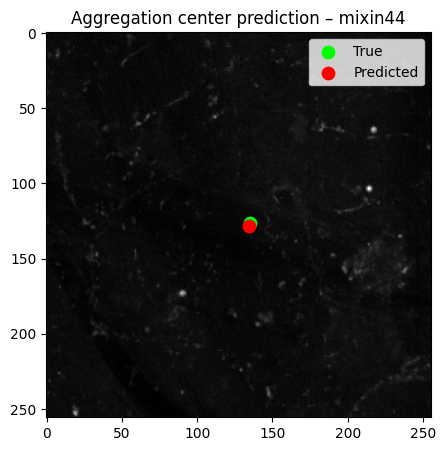

In [ ]:
# @title Visualization on mixin44
movie44 = movies["mixin_test44"]
cent44  = compute_center_of_mass(movie44, last_k=5)  # true center (cx, cy)

# build a single input window from the start of mixin44
N = 6
x44 = torch.from_numpy(movie44[:N]).unsqueeze(0).to(DEVICE)  # (1,N,H,W)

with torch.no_grad():
    pred44 = model2(x44).cpu().numpy()[0]    # (2,)

cx_true, cy_true = cent44
cx_pred, cy_pred = pred44

plt.figure(figsize=(5,5))
plt.imshow(movie44[-1], cmap="gray")
plt.scatter([cx_true], [cy_true], c="lime", s=80, label="True")
plt.scatter([cx_pred], [cy_pred], c="red", s=80, label="Predicted")
plt.legend()
plt.title("Aggregation center prediction – mixin44")
plt.show()



### 3.3 Model 3 – Heatmap predictor

- **Task:** From the first N frames (N=6), output a 2D heatmap \(P(y,x)\) over pixels.
- **Architecture options:**
  - Tiny U-Net / encoder-decoder, or reuse TinyCNN but change the output to be a single heatmap aligned with spatial dimensions of the movie.
- **Loss:**
  - MSE between predicted heatmap and a Gaussian “target map” centered at the aggregation center, **or**
  - Binary cross-entropy if using a thresholded mask of the aggregation region.

In [ ]:
import torch.nn.functional as F

def make_gaussian_heatmap(center_xy, H, W, sigma=5.0):
    """
    center_xy: (cx, cy) in pixel coords (float)
    returns heatmap (H, W) with values in [0,1]
    """
    cx, cy = center_xy
    ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    dist2 = (xs - cx)**2 + (ys - cy)**2
    heat = np.exp(-dist2 / (2 * sigma**2))
    heat = heat / (heat.max() + 1e-8)
    return heat.astype(np.float32)


class HeatmapDataset(Dataset):
    """
    Like CenterDataset, but target is a 2D gaussian heatmap
    centered at the aggregation COM.
    """
    def __init__(self, movie, N=6, last_k=5, stride=1, downsample=2, sigma=5.0):
        """
        movie     : (T, H, W)
        downsample: e.g. 2 -> 256x256 -> 128x128
        sigma     : std of Gaussian in *original* pixels
        """
        self.movie = movie.astype(np.float32)
        self.N = N
        self.stride = stride
        self.downsample = downsample

        # compute center once in original resolution
        self.center = compute_center_of_mass(movie, last_k=last_k)  # (cx, cy)

        T, H, W = movie.shape
        self.start_idxs = list(range(0, T - N, stride))

        # precompute ds shape and scaled center
        self.H_ds = H // downsample
        self.W_ds = W // downsample
        self.center_ds = np.array(
            [self.center[0] / downsample, self.center[1] / downsample],
            dtype=np.float32
        )
        # scale sigma as well
        self.sigma_ds = sigma / downsample

    def __len__(self):
        return len(self.start_idxs)

    def __getitem__(self, idx):
        i = self.start_idxs[idx]
        x = self.movie[i:i+self.N]          # (N, H, W)

        # downsample input frames (simple 2x2 average pooling via torch)
        x_t = torch.from_numpy(x).unsqueeze(0)   # (1, N, H, W)
        x_t = F.avg_pool2d(x_t, kernel_size=self.downsample)  # (1, N, H_ds, W_ds)
        x_ds = x_t.squeeze(0)                     # (N, H_ds, W_ds)

        # build gaussian heatmap in ds resolution
        heat = make_gaussian_heatmap(
            self.center_ds, self.H_ds, self.W_ds, sigma=self.sigma_ds
        )  # (H_ds, W_ds)

        return x_ds, torch.from_numpy(heat)


In [ ]:
# Build HeatmapDataset for each movie
heatmap_ds_list = []
for name, movie in movies.items():
    print(f"HeatmapDataset for {name}, movie shape={movie.shape}")
    heatmap_ds_list.append(
        HeatmapDataset(movie, N=6, last_k=5, stride=1, downsample=2, sigma=5.0)
    )

full_heatmap_ds = ConcatDataset(heatmap_ds_list)

n_total_h = len(full_heatmap_ds)
n_train_h = int(0.8 * n_total_h)
n_val_h   = n_total_h - n_train_h
train_heat_ds, val_heat_ds = random_split(
    full_heatmap_ds,
    [n_train_h, n_val_h],
    generator=torch.Generator().manual_seed(0)
)

train_heat_loader = DataLoader(train_heat_ds, batch_size=8, shuffle=True)
val_heat_loader   = DataLoader(val_heat_ds,   batch_size=8, shuffle=False)

print(f"[Heatmap] total={n_total_h}, train={n_train_h}, val={n_val_h}")


HeatmapDataset for mixin_test44, movie shape=(34, 256, 256)
HeatmapDataset for mixin_test57, movie shape=(40, 256, 256)
HeatmapDataset for mixin_test64, movie shape=(20, 256, 256)
[Heatmap] total=76, train=60, val=16


In [ ]:
class HeatmapCNN(nn.Module):
    def __init__(self, T=6):
        super().__init__()
        self.temporal = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(T,3,3), padding=(0,1,1)),
            nn.ReLU()
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1)   # 1-channel heatmap
        )

    def forward(self, x):
        """
        x: (B, T, H, W)  in downsampled resolution, e.g. 128x128
        """
        x = x.unsqueeze(1)              # (B,1,T,H,W)
        z = self.temporal(x).squeeze(2) # (B,8,H,W)
        out = self.spatial(z)           # (B,1,H,W)
        return torch.sigmoid(out)       # probabilities in [0,1]


[HeatmapCNN] epoch 001  train MSE=0.3008  val MSE=0.2846
[HeatmapCNN] epoch 010  train MSE=0.0013  val MSE=0.0013
[HeatmapCNN] epoch 020  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 030  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 040  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 050  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 060  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 070  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 080  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 090  train MSE=0.0012  val MSE=0.0012
[HeatmapCNN] epoch 100  train MSE=0.0012  val MSE=0.0012


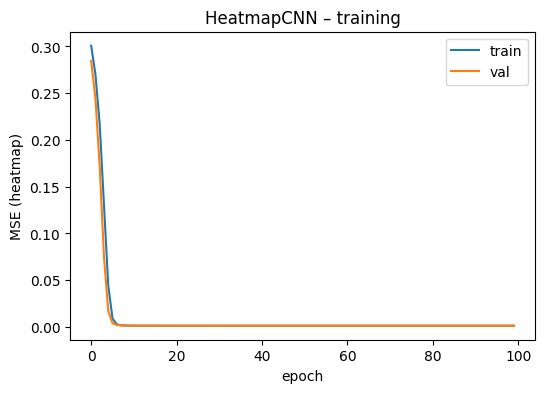

In [ ]:
set_seed(7)
model3 = HeatmapCNN(T=6).to(DEVICE)
opt3   = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-5)
loss3  = nn.MSELoss()

num_epochs = 100
train_h_losses, val_h_losses = [], []

for ep in range(1, num_epochs+1):
    # --- train ---
    model3.train()
    total_tr = 0.0
    for xb, yb in train_heat_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)   # xb: (B,T,H,W), yb: (B,H,W)
        opt3.zero_grad()
        pred = model3(xb).squeeze(1)           # (B,H,W)
        loss = loss3(pred, yb)
        loss.backward()
        opt3.step()
        total_tr += loss.item() * xb.size(0)
    tr_loss = total_tr / len(train_heat_ds)

    # --- val ---
    model3.eval()
    total_va = 0.0
    with torch.no_grad():
        for xb, yb in val_heat_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model3(xb).squeeze(1)
            loss = loss3(pred, yb)
            total_va += loss.item() * xb.size(0)
    va_loss = total_va / len(val_heat_ds)

    train_h_losses.append(tr_loss)
    val_h_losses.append(va_loss)

    if ep % 10 == 0 or ep == 1:
        print(f"[HeatmapCNN] epoch {ep:03d}  train MSE={tr_loss:.4f}  val MSE={va_loss:.4f}")

# plot curves
plt.figure(figsize=(6,4))
plt.plot(train_h_losses, label="train")
plt.plot(val_h_losses,   label="val")
plt.xlabel("epoch")
plt.ylabel("MSE (heatmap)")
plt.title("HeatmapCNN – training")
plt.legend()
plt.show()


In [ ]:
def center_from_heatmap(hm):
    """
    hm: (H, W) torch or numpy
    returns (cx, cy) in pixel coords
    """
    if isinstance(hm, torch.Tensor):
        hm_np = hm.detach().cpu().numpy()
    else:
        hm_np = hm
    H, W = hm_np.shape
    mass = hm_np.sum()
    if mass <= 1e-8:
        return np.array([W/2.0, H/2.0], dtype=np.float32)
    ys, xs = np.indices((H, W))
    cy = (hm_np * ys).sum() / mass
    cx = (hm_np * xs).sum() / mass
    return np.array([cx, cy], dtype=np.float32)


In [ ]:
# --- evaluate center error on heatmap model ---
px_to_um_ds = 2.41 * 2   # if downsample=2, each pixel ~ 2 * 2.41 um in original x-y

model3.eval()
all_errs = []

with torch.no_grad():
    for xb, yb in val_heat_loader:
        xb = xb.to(DEVICE)
        pred_hm = model3(xb).squeeze(1)   # (B,H,W)

        for i in range(pred_hm.size(0)):
            # predicted center from heatmap
            pred_c = center_from_heatmap(pred_hm[i])
            # true center (same for all windows from that movie)
            true_c = center_from_heatmap(yb[i])  # or you can directly use dataset.center_ds

            err_px = np.linalg.norm(pred_c - true_c)
            all_errs.append(err_px * px_to_um_ds)

all_errs = np.array(all_errs)
print("Heatmap model center error (µm) – val")
print("  mean:", all_errs.mean())
print("  std :", all_errs.std())
print("  min :", all_errs.min())
print("  max :", all_errs.max())


Heatmap model center error (µm) – val
  mean: 30.119953
  std : 10.260512
  min : 14.803029
  max : 48.80167


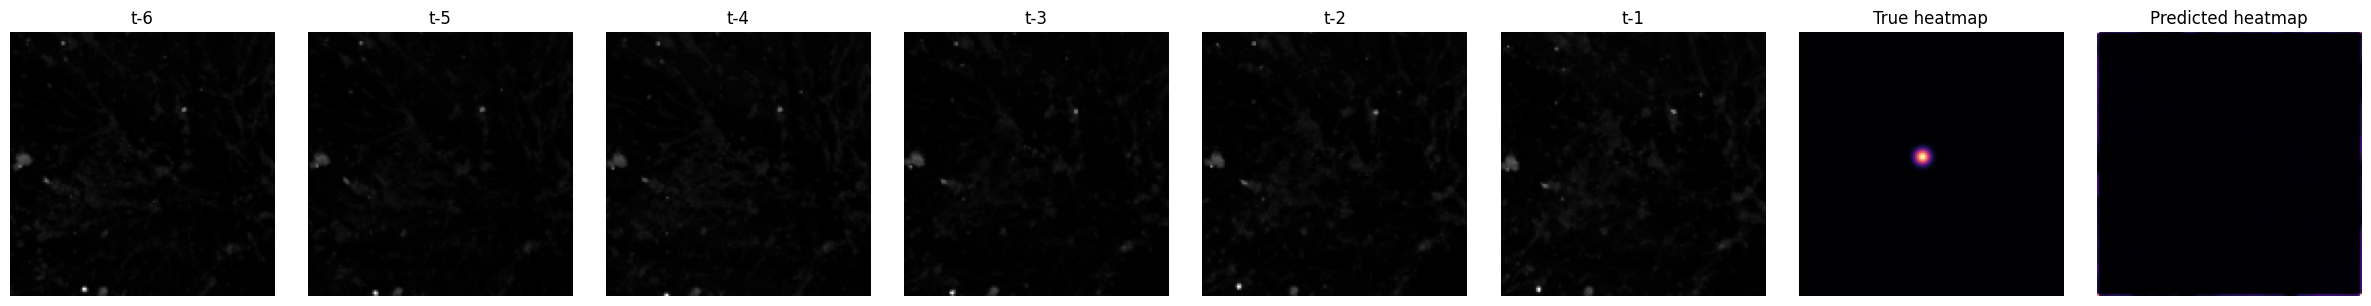

In [ ]:
# --- qualitative example: early frames + predicted heatmap ---
model3.eval()
xb, yb = val_heat_ds[0]          # one window
xb_in = xb.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred_hm = model3(xb_in).cpu().squeeze().numpy()

# xb: (T,H,W) at downsampled resolution
T, Hh, Wh = xb.shape
fig, axs = plt.subplots(1, T+2, figsize=(3*(T+2), 3))

for i in range(T):
    axs[i].imshow(xb[i], cmap="gray")
    axs[i].set_title(f"t-{T-i}")
    axs[i].axis("off")

axs[-2].imshow(yb.numpy(), cmap="magma")
axs[-2].set_title("True heatmap")
axs[-2].axis("off")

axs[-1].imshow(pred_hm, cmap="magma")
axs[-1].set_title("Predicted heatmap")
axs[-1].axis("off")

plt.tight_layout()
plt.show()


## 4. Results

### 4.1 Metrics

**Center error (µm).**  
For models 2 and 3, I measure the Euclidean distance between the predicted center $(\hat{x}, \hat{y})$ and ground truth $(x^*, y^*)$, converted to microns ($\mu$m):

$$
\text{CenterError}_\mu = \text{pixel\_size} \times \sqrt{(\hat{x} - x^*)^2 + (\hat{y} - y^*)^2}.
$$

I report mean ± standard deviation over test windows.

**Spatial map quality (optional).**  
If using a full heatmap, I can also report AUROC or average precision between predicted probability map and a binary mask around the true aggregation region.

**Resolution robustness.**  
Train on subsampled movies (e.g., subsampled timepoints / downsampled spatially) and test on higher resolution, and report the relative performance drop:

$$
\text{Drop}(\%) = 100 \cdot \frac{\text{Error}_\text{hires} - \text{Error}_\text{subsample}}{\text{Error}_\text{subsample}}.
$$


### 4.2 Quantitative results

For the first experiment (mixin44), the TinyCNN next-frame baseline reaches
a test MSE of **2×10⁻⁴** on normalized intensities:

- Train MSE after 20 epochs: ≈ **2×10⁻⁴**
- Validation MSE after 20 epochs: ≈ **2×10⁻⁴**
- Test MSE: **2×10⁻⁴**

This confirms that the spatio-temporal dynamics of the movie are highly
predictable with a small Conv3D+Conv2D model.

For the center-prediction models, I report Euclidean error in microns (using
a 10× pixel size of 2.41 μm):

**Table 1 – Center error for coordinate vs. heatmap models (validation windows)**

| Model                  | Input frames N | Downsample | Mean error (μm) | Std (μm) | Min (μm) | Max (μm) |
|------------------------|----------------|------------|-----------------|----------|----------|----------|
| CenterRegressor        | 6              | ×1         | **10.0**        | 3.2      | 5.3      | 15.0     |
| HeatmapCNN (COM of hm) | 6              | ×2 spatial | **30.1**        | 10.3     | 14.8     | 48.8     |

The coordinate regressor clearly outperforms the heatmap model: it can
predict the final aggregation center with an average error of about **10 μm**
(roughly 4 pixels at 2.41 μm/px), while the heatmap model is about three
times worse on this small dataset.

For completeness, the validation performance of the CenterRegressor in
pixel-squared MSE during training is:

- Final train MSE: ≈ **8.6 px²**
- Final validation MSE: ≈ **9.5 px²**

which corresponds to the ≈10 μm mean distance error reported above.


### 4.3 Figures

**Figure 1 – TinyCNN next-frame prediction.**  
Example from `mixin44` showing the last K input frames, the true next frame, and the TinyCNN prediction. The predicted frame closely matches the true one, which agrees with the low MSE values.

**Figure 2 – Aggregation center prediction (CenterRegressor).**  
For `mixin44`, I overlay the true aggregation center (computed from the last 5 frames) and the CenterRegressor prediction on the final frame of the movie. With N = 6 input frames, the predicted point falls very close to the true center, in line with the ~10 μm mean error.

**Figure 3 – Heatmap model (HeatmapCNN).**  
Example window from the validation set showing: the downsampled input frames, the target Gaussian heatmap, and the predicted heatmap. The prediction is roughly centered on the aggregate but more spread out, which explains the larger center error (~30 μm on average).


## 5. Discussion & Conclusion

**What worked.**  
The TinyCNN baseline reached a very low next-frame MSE (~2×10⁻⁴), showing that the movies are smooth enough for a small Conv3D+Conv2D network to predict short-term dynamics almost perfectly. Building on this, the CenterRegressor performed well on the main task: with only the first 6 frames, it achieved a mean center error of about 10 μm. This corresponds to just a few pixels at 10× resolution, and the visual overlays confirm that the predicted center lands very close to the true intensity-weighted center of mass.

**What was harder.**  
The heatmap model was noticeably less precise. Even after 100 epochs, its center error remained around 30 μm, roughly three times worse than the coordinate regressor. The predicted heatmaps tend to be broader and lower contrast than the target Gaussian, which naturally shifts their center of mass. This is consistent with the small dataset (76 windows), the downsampled inputs, and the fact that heatmap prediction is a harder problem than outputting two coordinates.

**Limitations and next steps.**  
All models were trained on only three experiments, so they may not generalize broadly. The ground-truth definition also assumes a single dominant aggregation site, which works for these movies but may not hold in more complex conditions. Future extensions could include:
- adding motion information,
- predicting multiple centers with a mixture of Gaussians,
- or estimating uncertainty to show how confident the model is about early predictions.

Overall, the results show that relatively simple CNNs can anticipate the final aggregation site of *Dictyostelium* from just a handful of early frames. The dynamics contain strong early cues, and even small models can extract them.